# Notebook pour nettoyer la donnée du datathon 2024

### Problématique : Je suis un propriétaire qui souhaite louer mon appartement, mais je ne sais pas quelle période me rapportera le plus d’argent ( évènements ou autre bonifie le prix de location).

Dataset : https://insideairbnb.com/get-the-data/

On prend les données de Lyon : 23 March, 2024 . 15 December, 2023  
Taille : environ 300 Mo

Types de données des colonnes :
root
 |-- listing_id: long (nullable = true)
 |-- date: date (nullable = true)
 |-- available: string (nullable = true)
 |-- price: string (nullable = true)
 |-- adjusted_price: string (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- maximum_nights: integer (nullable = true)



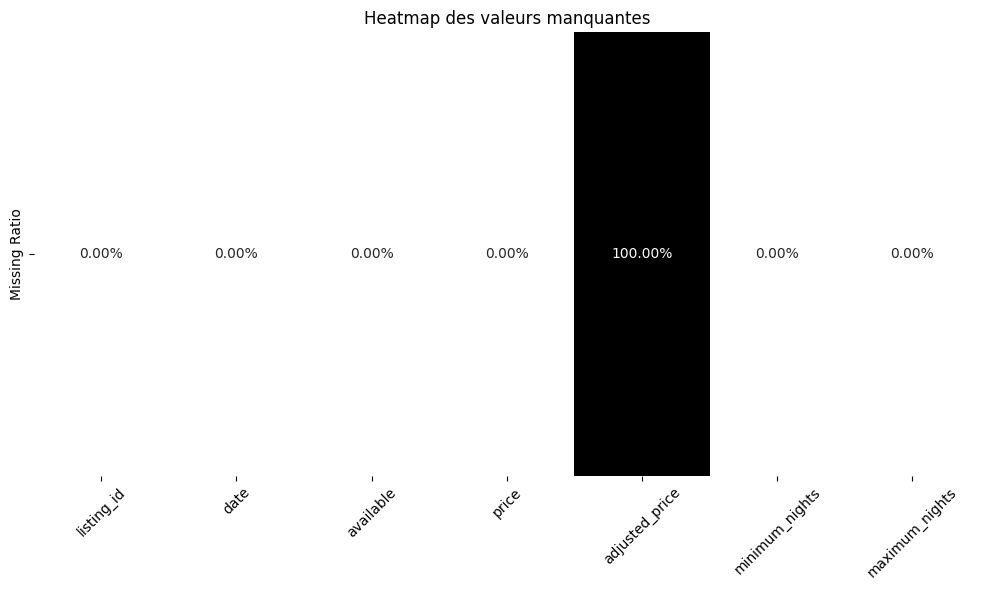

In [36]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Initialiser une session Spark
spark = SparkSession.builder \
    .appName("Gestion des données Spark") \
    .getOrCreate()

# Définir les chemins des dossiers
dataset_path = os.path.abspath('../Data')
dataset_raw_path = os.path.abspath('../Data/Raw')

cleaned_data_path = os.path.join(dataset_path, 'Cleaned')
final_data_path = os.path.join(dataset_path, 'Final')

cleaned_december = os.path.join(cleaned_data_path, 'Data_15_Decembre_2023')
final_december = os.path.join(final_data_path, 'Data_15_Decembre_2023')
cleaned_march = os.path.join(cleaned_data_path, 'Data_23_March_2024')
final_march = os.path.join(final_data_path, 'Data_23_March_2024')

# Créer les sous-dossiers s'ils n'existent pas
os.makedirs(cleaned_december, exist_ok=True)
os.makedirs(final_december, exist_ok=True)
os.makedirs(cleaned_march, exist_ok=True)
os.makedirs(final_march, exist_ok=True)

# Chargement du CSV
dataset_calendar = os.path.join(dataset_raw_path, 'Data_15_Decembre_2023', 'calendar.csv')
df = spark.read.csv(dataset_calendar, header=True, inferSchema=True)

# Afficher les types de données
print("Types de données des colonnes :")
df.printSchema()

# Calcul des valeurs manquantes pour chaque colonne
missing_data = df.select(
    [(count(when(col(c).isNull(), c)) / count("*")).alias(c) for c in df.columns]
).collect()[0]

# Préparer les données pour Matplotlib
missing_ratios = {col_name: missing_data[col_name] for col_name in df.columns}
columns = list(missing_ratios.keys())
values = list(missing_ratios.values())

# Créer une heatmap des valeurs manquantes
plt.figure(figsize=(10, 6))
sns.heatmap(
    [values],
    annot=True,
    fmt=".2%",
    xticklabels=columns,
    yticklabels=['Missing Ratio'],
    cmap=['white', 'black'],
    cbar=False,
)
plt.xticks(rotation=45)
plt.title("Heatmap des valeurs manquantes")
plt.tight_layout()

# Afficher la heatmap
plt.show()


On se rend compte qu'il y a un manque de donnée uniquement sur adjusted_price on drop donc la colonne et on sauvegarde le fichier cleaned

Pour le typing on observe en PowerBI que le price, est en $Number donc un string on va changer, le nom de la colonne en price_dollar et la data en number

In [37]:
from pyspark.sql.functions import col, regexp_replace
import os

# Renommer la colonne 'price' en 'price_dollar'
df = df.withColumnRenamed('price', 'price_dollar')

# Convertir les valeurs de 'price_dollar' en nombres
df = df.withColumn('price_dollar', regexp_replace(col('price_dollar'), r'[\$,]', '').cast('float'))

# Supprimer la colonne 'adjusted_price'
df = df.drop('adjusted_price')

# Afficher les types de données des colonnes après modification
print("Types de données des colonnes après modification:")
df.printSchema()

# Définir le chemin pour sauvegarder le nouveau fichier
cleaned_file_path = os.path.abspath(os.path.join(cleaned_december, 'calendar_cleaned.csv'))

# Sauvegarder le DataFrame en tant que CSV
df.write.csv(cleaned_file_path, header=True, mode='overwrite')
print(f"Le fichier nettoyé a été sauvegardé à l'emplacement: {cleaned_file_path}")


Types de données des colonnes après modification:
root
 |-- listing_id: long (nullable = true)
 |-- date: date (nullable = true)
 |-- available: string (nullable = true)
 |-- price_dollar: float (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- maximum_nights: integer (nullable = true)

Le fichier nettoyé a été sauvegardé à l'emplacement: c:\Users\pierr\OneDrive\Bureau\Work\CPE\5ETI\Big_Data\Datathon\datathon-2024\Data\Cleaned\Data_15_Decembre_2023\calendar_cleaned.csv


#### listing_detailed.csv

Nos features :  id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month

Enormement de features on va en drop pas mal

Colonne: latitude, Type: double
Colonne: longitude, Type: double


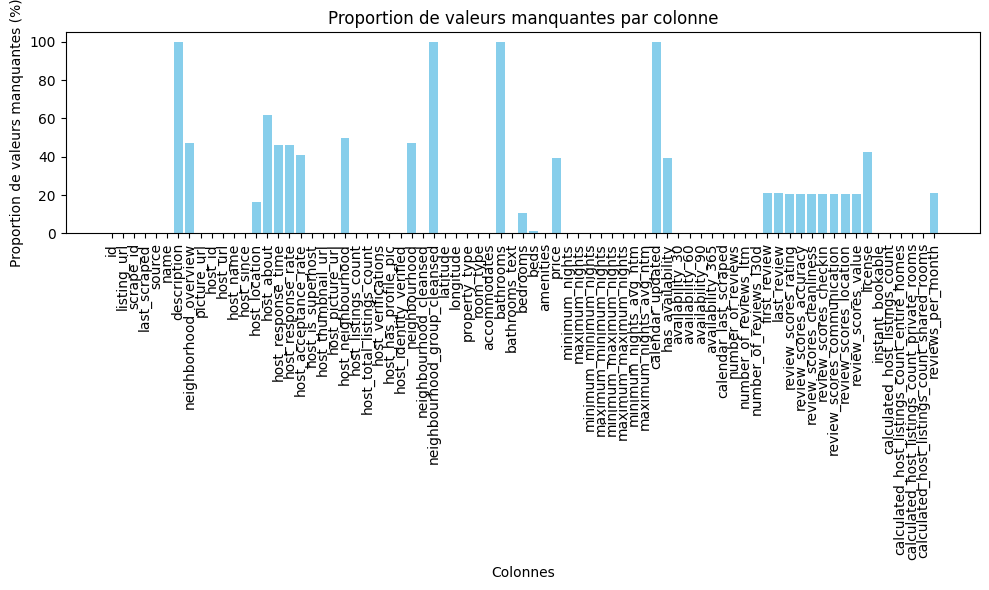

In [38]:
import sys
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col

import pyspark.sql.functions as F
import pandas as pd


# Chargerment des fichiers
listings_path = os.path.join(dataset_raw_path, 'Data_15_Decembre_2023', 'listings_detailed.csv')
calendar_path = os.path.join(dataset_raw_path, 'Data_15_Decembre_2023', 'calendar.csv')

# Charger les fichiers en DataFrames Spark
listings = spark.read.csv(listings_path, header=True, inferSchema=True, multiLine=True, escape="\"")
calendar = spark.read.csv(calendar_path, header=True, inferSchema=True)


# Afficher les types de toutes les colonnes
column_types = listings.dtypes
# Afficher uniquement les types des colonnes 'longitude' et 'latitude'
for col_name, col_type in column_types:
    if col_name in ['longitude', 'latitude']:
        print(f"Colonne: {col_name}, Type: {col_type}")

# Convertir 'longitude' et 'latitude' en float
listings = listings.withColumn("longitude", col("longitude").cast("float")) \
                         .withColumn("latitude", col("latitude").cast("float"))
                         

# Calculer le nombre de valeurs manquantes pour chaque colonne
missing_count_df = listings.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in listings.columns]
)

# Récupérer le nombre total de lignes dans le DataFrame
total_rows = listings.count()

# Collecter les résultats en un dictionnaire
missing_counts = missing_count_df.collect()[0].asDict()

# Calculer le pourcentage de valeurs manquantes pour chaque colonne
missing_percentage = {col: (missing_counts[col] / total_rows) * 100 for col in missing_counts}

# Visualiser le nombre de valeurs manquantes proportionnellement à la taille de la colonne
columns = list(missing_percentage.keys())
values = list(missing_percentage.values())

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.bar(columns, values, color='skyblue')

# Ajouter les labels et titre
plt.xlabel('Colonnes')
plt.ylabel('Proportion de valeurs manquantes (%)')
plt.title('Proportion de valeurs manquantes par colonne')
plt.xticks(rotation=90)
plt.tight_layout()

# Afficher l'histogramme
plt.show()





On s'apercoit que on a beaucoup de problème avec les prix qui sont vides on fait donc une jointure avec la table calendar avec listing_id/id pour remplir les price de listings_detailed avec les price remplies de calendar

Pourcentage de valeurs manquantes dans la colonne 'price' : 0.00%


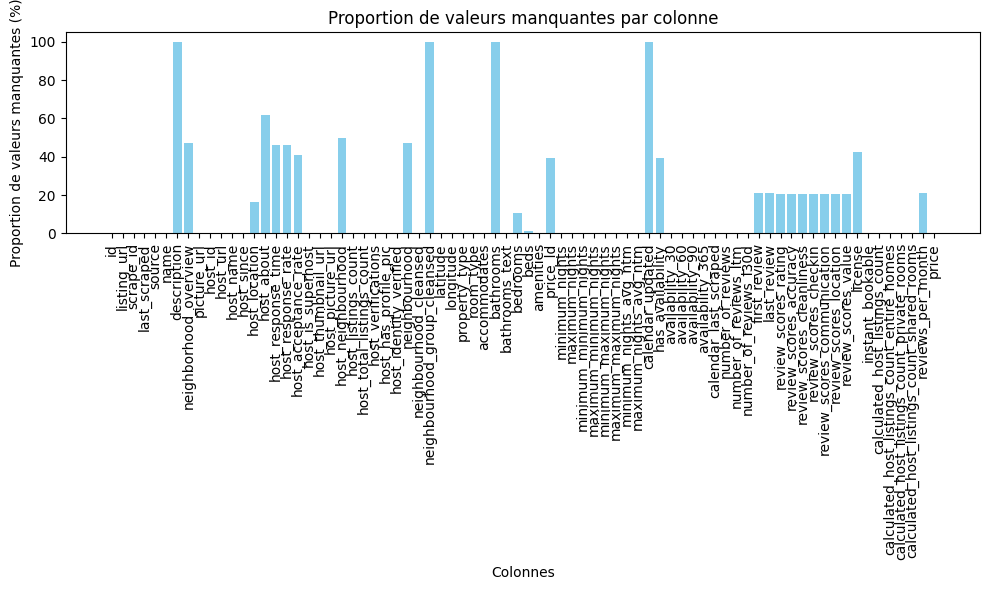

In [39]:
from pyspark.sql.functions import when, col, count

calendar = spark.read.csv(calendar_path, header=True, inferSchema=True)

from pyspark.sql.functions import col, when

# Renommer la colonne 'price' dans les deux DataFrames avant la jointure
listings_detailed_renamed = listings.withColumnRenamed("price", "price_ld")
calendar_renamed = calendar.withColumnRenamed("price", "price_cal")

# Effectuer la jointure entre les deux DataFrames
joined_df = listings_detailed_renamed.alias("l").join(
    calendar_renamed.alias("c"),
    col("l.id") == col("c.listing_id"),
    how="left"
)

# Mettre à jour la colonne 'price' dans 'listings_detailed' avec les valeurs de 'calendar' là où 'price_ld' est null
updated_df = joined_df.withColumn(
    "price",
    when(col("l.price_ld").isNull(), col("c.price_cal")).otherwise(col("l.price_ld"))
).select("l.*", "price")  # Sélectionner toutes les colonnes de listings_detailed et la colonne 'price'

# Calcul du nombre de valeurs manquantes dans la colonne 'price'
missing_values_count = updated_df.filter(col("price").isNull()).count()

# Calcul du nombre total de lignes dans le DataFrame
total_count = updated_df.count()

# Calcul du pourcentage de valeurs manquantes
missing_percentage = (missing_values_count / total_count) * 100

# Afficher le pourcentage de valeurs manquantes
print(f"Pourcentage de valeurs manquantes dans la colonne 'price' : {missing_percentage:.2f}%")


# Calculer le nombre de valeurs manquantes pour chaque colonne
missing_count_df = updated_df.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in updated_df.columns]
)

# Récupérer le nombre total de lignes dans le DataFrame
total_rows = updated_df.count()

# Collecter les résultats en un dictionnaire
missing_counts = missing_count_df.collect()[0].asDict()

# Calculer le pourcentage de valeurs manquantes pour chaque colonne
missing_percentage = {col: (missing_counts[col] / total_rows) * 100 for col in missing_counts}

# Visualiser le nombre de valeurs manquantes proportionnellement à la taille de la colonne
columns = list(missing_percentage.keys())
values = list(missing_percentage.values())

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.bar(columns, values, color='skyblue')

# Ajouter les labels et titre
plt.xlabel('Colonnes')
plt.ylabel('Proportion de valeurs manquantes (%)')
plt.title('Proportion de valeurs manquantes par colonne')
plt.xticks(rotation=90)
plt.tight_layout()

# Afficher l'histogramme
plt.show()



Pourcentage de valeurs manquantes par colonne :
id: 0.00%
listing_url: 0.00%
scrape_id: 0.00%
last_scraped: 0.00%
source: 0.00%
name: 0.00%
description: 100.00%
neighborhood_overview: 47.26%
picture_url: 0.00%
host_id: 0.00%
host_url: 0.00%
host_name: 0.02%
host_since: 0.02%
host_location: 16.47%
host_about: 61.75%
host_response_time: 46.01%
host_response_rate: 46.01%
host_acceptance_rate: 40.99%
host_is_superhost: 0.12%
host_thumbnail_url: 0.02%
host_picture_url: 0.02%
host_neighbourhood: 49.92%
host_listings_count: 0.02%
host_total_listings_count: 0.02%
host_verifications: 0.02%
host_has_profile_pic: 0.02%
host_identity_verified: 0.02%
neighbourhood: 47.26%
neighbourhood_cleansed: 0.00%
neighbourhood_group_cleansed: 100.00%
latitude: 0.00%
longitude: 0.00%
property_type: 0.00%
room_type: 0.00%
accommodates: 0.00%
bathrooms: 100.00%
bathrooms_text: 0.02%
bedrooms: 10.87%
beds: 0.97%
amenities: 0.00%
price_ld: 39.35%
minimum_nights: 0.00%
maximum_nights: 0.00%
minimum_minimum_nights: 0

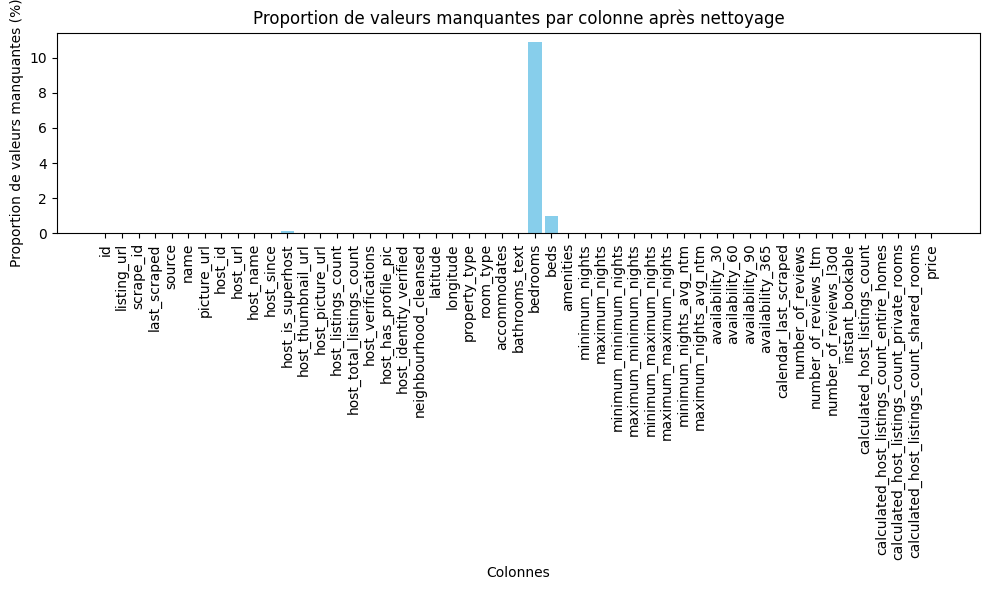

In [40]:
from pyspark.sql.functions import col, when, count
# Calcul du nombre de valeurs manquantes dans chaque colonne avant de supprimer
missing_count_df = updated_df.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in updated_df.columns]
)

# Récupérer le nombre total de lignes
total_rows = updated_df.count()

# Collecter les résultats en un dictionnaire
missing_counts = missing_count_df.collect()[0].asDict()

# Calculer le pourcentage de valeurs manquantes pour chaque colonne
missing_percentage = {col: (missing_counts[col] / total_rows) * 100 for col in missing_counts}

# Afficher les pourcentages de valeurs manquantes
print("Pourcentage de valeurs manquantes par colonne :")
for col_name, percentage in missing_percentage.items():
    print(f"{col_name}: {percentage:.2f}%")

# Filtrer les colonnes avec plus de 15 % de valeurs manquantes
columns_to_keep = [col for col, pct in missing_percentage.items() if pct <= 15]

# Appliquer la sélection des colonnes pour ne garder que celles qui ont moins de 15 % de valeurs manquantes
updated_df_cleaned = updated_df.select(*columns_to_keep)

# Afficher les colonnes restantes
print(f"Colonnes restantes après suppression des colonnes avec plus de 15% de valeurs manquantes : {updated_df_cleaned.columns}")

# Calculer à nouveau le nombre de valeurs manquantes pour les colonnes restantes
missing_count_cleaned_df = updated_df_cleaned.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in updated_df_cleaned.columns]
)

# Recalculer le pourcentage de valeurs manquantes après suppression
missing_counts_cleaned = missing_count_cleaned_df.collect()[0].asDict()
missing_percentage_cleaned = {col: (missing_counts_cleaned[col] / total_rows) * 100 for col in missing_counts_cleaned}

# Afficher les pourcentages de valeurs manquantes après suppression
print("Pourcentage de valeurs manquantes après suppression des colonnes avec plus de 15% de valeurs manquantes :")
for col_name, percentage in missing_percentage_cleaned.items():
    print(f"{col_name}: {percentage:.2f}%")

# Visualisation des valeurs manquantes après la suppression des colonnes
columns_cleaned = list(missing_percentage_cleaned.keys())
values_cleaned = list(missing_percentage_cleaned.values())

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.bar(columns_cleaned, values_cleaned, color='skyblue')

# Ajouter les labels et titre
plt.xlabel('Colonnes')
plt.ylabel('Proportion de valeurs manquantes (%)')
plt.title('Proportion de valeurs manquantes par colonne après nettoyage')
plt.xticks(rotation=90)
plt.tight_layout()

# Afficher l'histogramme
plt.show()

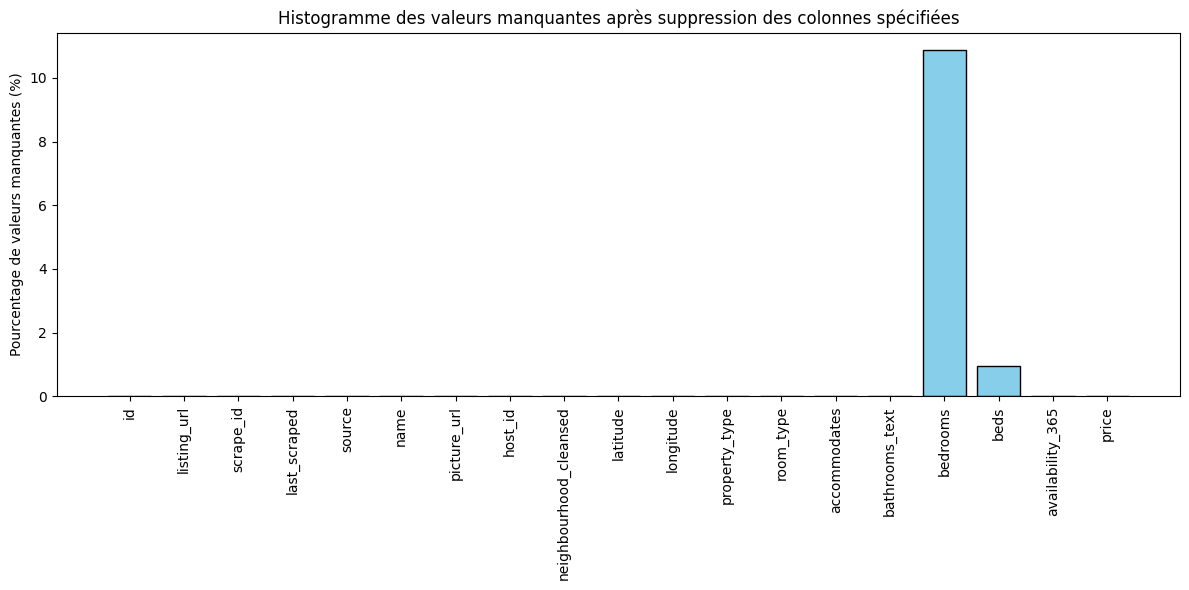

Features restantes après suppression des colonnes spécifiées:
['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'picture_url', 'host_id', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'availability_365', 'price']


In [42]:
import matplotlib.pyplot as plt

# Liste des colonnes à supprimer
columns_to_drop = [
    'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 
    'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
    'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 
    'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
    'availability_30', 'availability_60', 'availability_90', 'amenities', 'host_location', 'host_is_superhost',
    'host_url', 'host_name', 'host_since', 'host_thumbnail_url',
    'host_picture_url', 'host_listings_count', 'host_total_listings_count',
    'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighborhood_cleansed', 'first_review', 'last_review',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value', 'license', 'jurisdiction_names', 'reviews_per_month'
]

# Supprimer les colonnes spécifiées
listings_cleaned = updated_df_cleaned.drop(*columns_to_drop)


# Recalculer les pourcentages de valeurs manquantes pour les colonnes restantes
missing_percentage_cleaned_df = listings_cleaned.select(
    [(count(when(col(c).isNull(), c)) / count("*") * 100).alias(c) for c in listings_cleaned.columns]
)

missing_percentage_cleaned = missing_percentage_cleaned_df.collect()[0].asDict()

# Créer un histogramme des valeurs manquantes après suppression
plt.figure(figsize=(12, 6))
plt.bar(
    missing_percentage_cleaned.keys(),
    missing_percentage_cleaned.values(),
    color='skyblue',
    edgecolor='black'
)
plt.xticks(rotation=90)
plt.ylabel("Pourcentage de valeurs manquantes (%)")
plt.title("Histogramme des valeurs manquantes après suppression des colonnes spécifiées")
plt.tight_layout()
plt.show()

# Afficher les colonnes restantes
remaining_columns = listings_cleaned.columns
print("Features restantes après suppression des colonnes spécifiées:")
print(remaining_columns)


On va supposer le nombre de bedrooms en fonction du nombre de beds

root
 |-- id: long (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: long (nullable = true)
 |-- last_scraped: date (nullable = true)
 |-- source: string (nullable = true)
 |-- name: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- bathrooms_text: string (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- price: string (nullable = true)



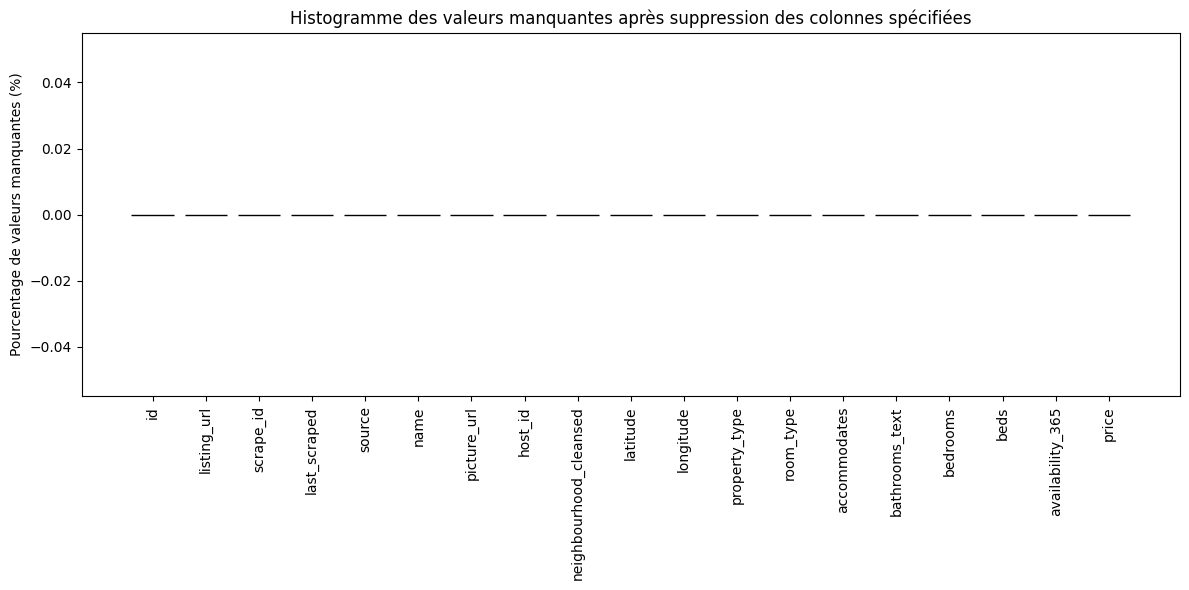

In [44]:
# Remplacer les valeurs manquantes dans la colonne 'bedrooms'
listings_cleaned = listings_cleaned.withColumn(
    "bedrooms",
    F.when(F.col("bedrooms").isNull(), F.greatest(F.lit(1), F.round(F.col("beds") / 2))).otherwise(F.col("bedrooms"))
)

# Supprimer les lignes contenant des valeurs nulles dans n'importe quelle colonne
listings_cleaned = listings_cleaned.dropna()

# Optionnel : Afficher le schéma du DataFrame nettoyé après suppression des lignes avec des valeurs nulles
listings_cleaned.printSchema()


# Recalculer les pourcentages de valeurs manquantes pour les colonnes restantes
missing_percentage_cleaned_df = listings_cleaned.select(
    [(count(when(col(c).isNull(), c)) / count("*") * 100).alias(c) for c in listings_cleaned.columns]
)

missing_percentage_cleaned = missing_percentage_cleaned_df.collect()[0].asDict()

# Créer un histogramme des valeurs manquantes après suppression
plt.figure(figsize=(12, 6))
plt.bar(
    missing_percentage_cleaned.keys(),
    missing_percentage_cleaned.values(),
    color='skyblue',
    edgecolor='black'
)
plt.xticks(rotation=90)
plt.ylabel("Pourcentage de valeurs manquantes (%)")
plt.title("Histogramme des valeurs manquantes après suppression des colonnes spécifiées")
plt.tight_layout()
plt.show()